In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data1=pd.read_csv('/content/drive/MyDrive/dosdata/data1.csv')
data2=pd.read_csv('/content/drive/MyDrive/dosdata/data2.csv')
data3=pd.read_csv('/content/drive/MyDrive/dosdata/data3.csv')

train_data=pd.concat([data1,data2,data3]).reset_index(drop=True)

train_data = train_data.drop(columns='Unnamed: 0')

train_data["Label"] = train_data["Label"].replace(["Benign","Anomaly"],[0,1])
for label, index in zip(['Benign', 'Anomaly'], [0, 1]):
    print(f"{label}: {index}")

Mounted at /content/drive
Benign: 0
Anomaly: 1


In [ ]:
print(train_data["Label"].value_counts())

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

X = train_data.drop("Label", axis=1)
y = train_data["Label"]

undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(X, y)

print(Counter(y))

Label
0    1567950
1    1000448
Name: count, dtype: int64
Counter({0: 1000448, 1: 1000448})


In [ ]:
!pip install scikit-learn
import pandas as pd
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler  # Import MinMaxScaler

def optimize_naive_bayes(X, y, cv=5):
    """
    Optimizes hyperparameters for Gaussian, Multinomial, and Bernoulli Naive Bayes classifiers
    using GridSearchCV and StratifiedKFold cross-validation.

    Args:
        X (array-like): Input features.
        y (array-like): Target variable.
        cv (int, optional): Number of cross-validation folds. Defaults to 5.

    Returns:
        tuple: A tuple containing the best estimator and a DataFrame of cross-validation results.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    param_grids = {
        'gaussian': {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        },
        'multinomial': {
            'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
            'fit_prior': [True, False]
        },
        'bernoulli': {
            'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
            'fit_prior': [True, False]
        }
    }

    nb_classifiers = {
        'gaussian': GaussianNB(),
        'multinomial': MultinomialNB(),
        'bernoulli': BernoulliNB()
    }

    best_estimator = None
    best_score = 0
    best_results = None

    for nb_type, nb_classifier in nb_classifiers.items():
        print(f"Optimizing {nb_type} Naive Bayes...")

        # Apply MinMaxScaler if using MultinomialNB
        if nb_type == 'multinomial':
            scaler = MinMaxScaler() # Create a MinMaxScaler object
            X_scaled = scaler.fit_transform(X) # Scale the data to the range [0, 1]
        else:
            X_scaled = X # If not MultinomialNB, use the original data

        grid_search = GridSearchCV(
            estimator=nb_classifier,
            param_grid=param_grids[nb_type],
            cv=skf,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_scaled, y) # Fit the model with scaled data if necessary

        print(f"Best Parameters for {nb_type}:", grid_search.best_params_)
        print(f"Best Cross-Validation Score for {nb_type}:", grid_search.best_score_)

        cv_results = pd.DataFrame(grid_search.cv_results_)
        cv_results = cv_results[['params', 'mean_test_score', 'std_test_score']]
        cv_results = cv_results.sort_values('mean_test_score', ascending=False).head()

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_estimator = grid_search.best_estimator_
            best_results = cv_results

    return best_estimator, best_results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
best_model, cv_results = optimize_naive_bayes(X_train, y_train)

Optimizing gaussian Naive Bayes...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for gaussian: {'var_smoothing': 1e-09}
Best Cross-Validation Score for gaussian: 0.6229274899199501
Optimizing multinomial Naive Bayes...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for multinomial: {'alpha': 0.1, 'fit_prior': True}
Best Cross-Validation Score for multinomial: 0.5818871053830308
Optimizing bernoulli Naive Bayes...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for bernoulli: {'alpha': 0.1, 'fit_prior': True}
Best Cross-Validation Score for bernoulli: 0.74065730650152


In [ ]:
print("\nTop 5 model performance:")
print(cv_results)


Top 5 model performance:
                               params  mean_test_score  std_test_score
0   {'alpha': 0.1, 'fit_prior': True}         0.740657        0.000735
1  {'alpha': 0.1, 'fit_prior': False}         0.740657        0.000735
2   {'alpha': 0.5, 'fit_prior': True}         0.740657        0.000735
3  {'alpha': 0.5, 'fit_prior': False}         0.740657        0.000735
4   {'alpha': 1.0, 'fit_prior': True}         0.740657        0.000735


In [ ]:
y_pred = best_model.predict(X_test)
print("\nTest set performance metrics:")
print(classification_report(y_test, y_pred))


Test set performance metrics:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75    200069
           1       0.77      0.69      0.73    200111

    accuracy                           0.74    400180
   macro avg       0.74      0.74      0.74    400180
weighted avg       0.74      0.74      0.74    400180



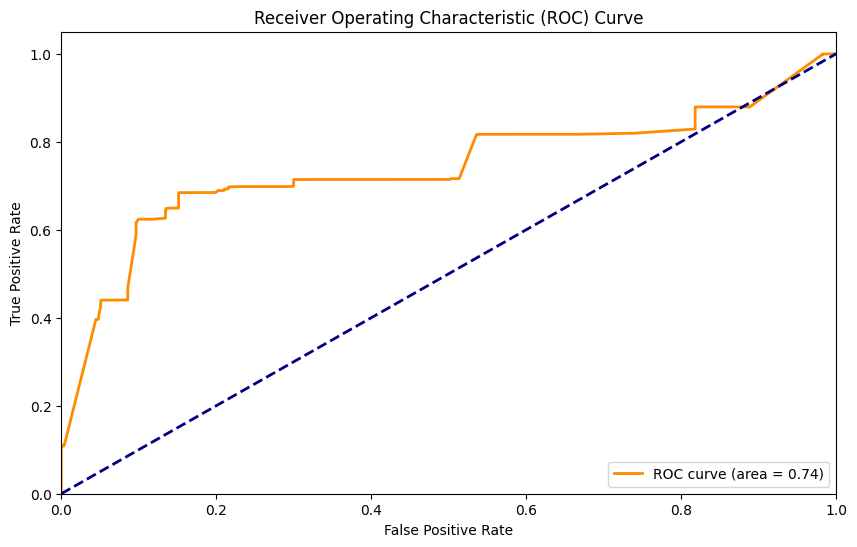

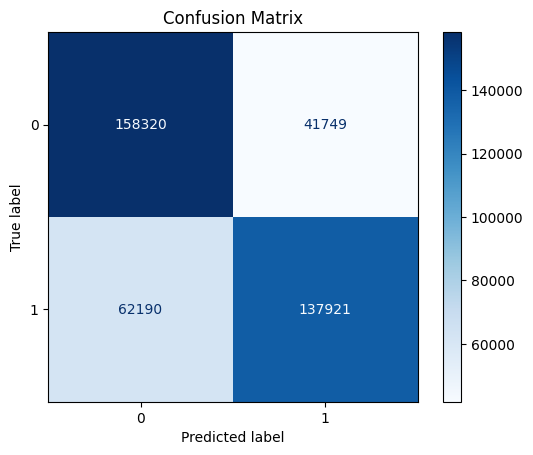

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



--------------------------------------------------
Evaluating gaussian Naive Bayes...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Parameters for gaussian: {'var_smoothing': 1e-09}
Best Cross-Validation Score: 0.6229

Fold 1 Metrics:
Accuracy: 0.6230
Precision: 0.8691
Recall: 0.2896
F1-Score: 0.4344
AUC-ROC: 0.5767

Confusion Matrix:
TN: 153093, FP: 6983
FN: 113720, TP: 46348

Fold 2 Metrics:
Accuracy: 0.6223
Precision: 0.8680
Recall: 0.2885
F1-Score: 0.4331
AUC-ROC: 0.5737

Confusion Matrix:
TN: 153052, FP: 7023
FN: 113883, TP: 46185

Fold 3 Metrics:
Accuracy: 0.6230
Precision: 0.8697
Recall: 0.2893
F1-Score: 0.4341
AUC-ROC: 0.5755

Confusion Matrix:
TN: 153139, FP: 6937
FN: 113765, TP: 46302

Fold 4 Metrics:
Accuracy: 0.6236
Precision: 0.8687
Recall: 0.2911
F1-Score: 0.4361
AUC-ROC: 0.5771

Confusion Matrix:
TN: 153036, FP: 7040
FN: 113475, TP: 46592

Fold 5 Metrics:
Accuracy: 0.6228
Precision: 0.8690
Recall: 0.2892
F1-Score: 0.4339
AUC-ROC: 0.5771

Confusion Ma

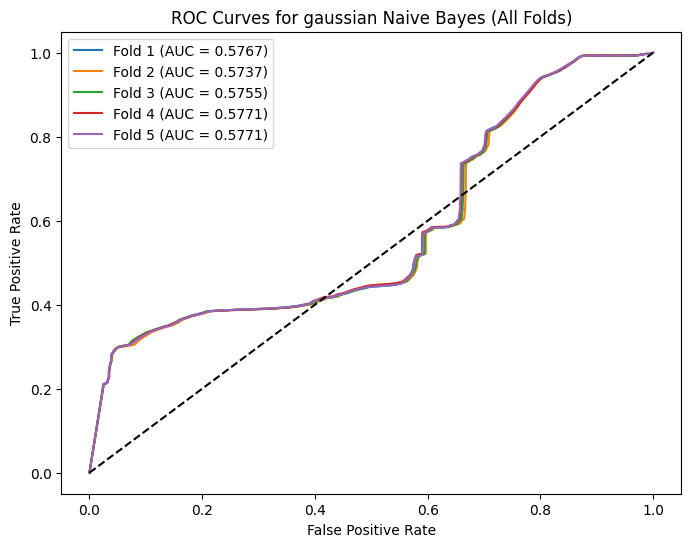


--------------------------------------------------
Evaluating multinomial Naive Bayes...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters for multinomial: {'alpha': 0.1, 'fit_prior': True}
Best Cross-Validation Score: 0.5819

Fold 1 Metrics:
Accuracy: 0.5821
Precision: 0.6991
Recall: 0.2881
F1-Score: 0.4081
AUC-ROC: 0.6504

Confusion Matrix:
TN: 140231, FP: 19845
FN: 113952, TP: 46116

Fold 2 Metrics:
Accuracy: 0.5807
Precision: 0.6949
Recall: 0.2877
F1-Score: 0.4069
AUC-ROC: 0.6506

Confusion Matrix:
TN: 139860, FP: 20215
FN: 114022, TP: 46046

Fold 3 Metrics:
Accuracy: 0.5818
Precision: 0.7024
Recall: 0.2837
F1-Score: 0.4042
AUC-ROC: 0.6458

Confusion Matrix:
TN: 140836, FP: 19240
FN: 114654, TP: 45413

Fold 4 Metrics:
Accuracy: 0.5824
Precision: 0.7013
Recall: 0.2872
F1-Score: 0.4075
AUC-ROC: 0.6495

Confusion Matrix:
TN: 140496, FP: 19580
FN: 114101, TP: 45966

Fold 5 Metrics:
Accuracy: 0.5817
Precision: 0.6982
Recall: 0.2877
F1-Score: 0.4074
AUC-ROC: 

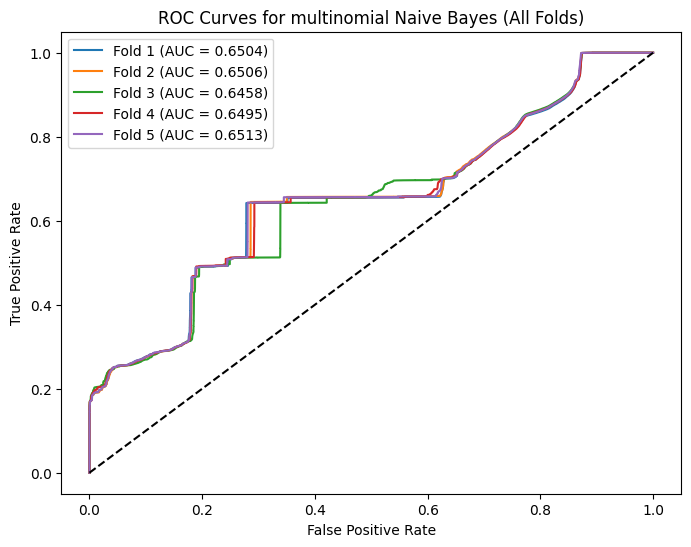


--------------------------------------------------
Evaluating bernoulli Naive Bayes...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters for bernoulli: {'alpha': 0.1, 'fit_prior': True}
Best Cross-Validation Score: 0.7407

Fold 1 Metrics:
Accuracy: 0.7396
Precision: 0.7663
Recall: 0.6895
F1-Score: 0.7259
AUC-ROC: 0.7399

Confusion Matrix:
TN: 126420, FP: 33656
FN: 49702, TP: 110366

Fold 2 Metrics:
Accuracy: 0.7408
Precision: 0.7686
Recall: 0.6889
F1-Score: 0.7266
AUC-ROC: 0.7407

Confusion Matrix:
TN: 126868, FP: 33207
FN: 49790, TP: 110278

Fold 3 Metrics:
Accuracy: 0.7410
Precision: 0.7683
Recall: 0.6902
F1-Score: 0.7271
AUC-ROC: 0.7408

Confusion Matrix:
TN: 126750, FP: 33326
FN: 49590, TP: 110477

Fold 4 Metrics:
Accuracy: 0.7418
Precision: 0.7697
Recall: 0.6899
F1-Score: 0.7276
AUC-ROC: 0.7423

Confusion Matrix:
TN: 127035, FP: 33041
FN: 49630, TP: 110437

Fold 5 Metrics:
Accuracy: 0.7401
Precision: 0.7670
Recall: 0.6898
F1-Score: 0.7264
AUC-ROC: 0.74

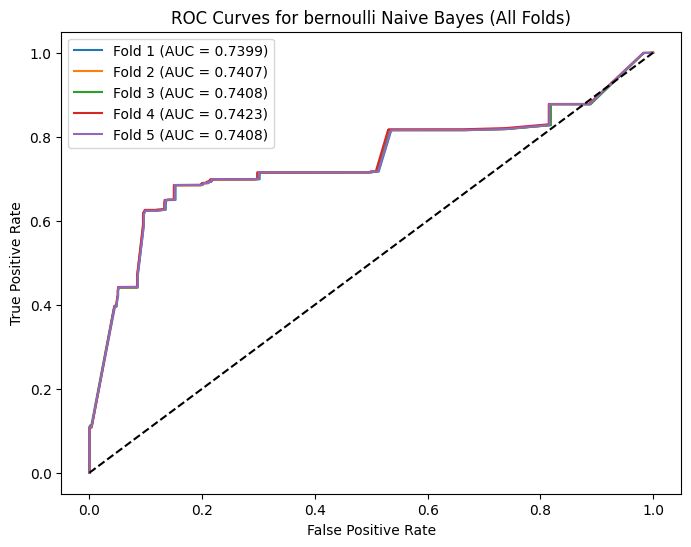


Average Metrics by Model Type:
             accuracy           precision              recall            \
                 mean       std      mean       std      mean       std   
model_type                                                                
bernoulli    0.740657  0.000821  0.767970  0.001338  0.689678  0.000481   
gaussian     0.622927  0.000438  0.868902  0.000612  0.289517  0.000949   
multinomial  0.581729  0.000649  0.699193  0.002912  0.286860  0.001791   

                   f1             auc_roc            
                 mean       std      mean       std  
model_type                                           
bernoulli    0.726721  0.000687  0.740901  0.000881  
gaussian     0.434318  0.001082  0.576017  0.001484  
multinomial  0.406809  0.001529  0.649537  0.002168  

Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75    200069
           1       0.77      0.69      0.73    200111



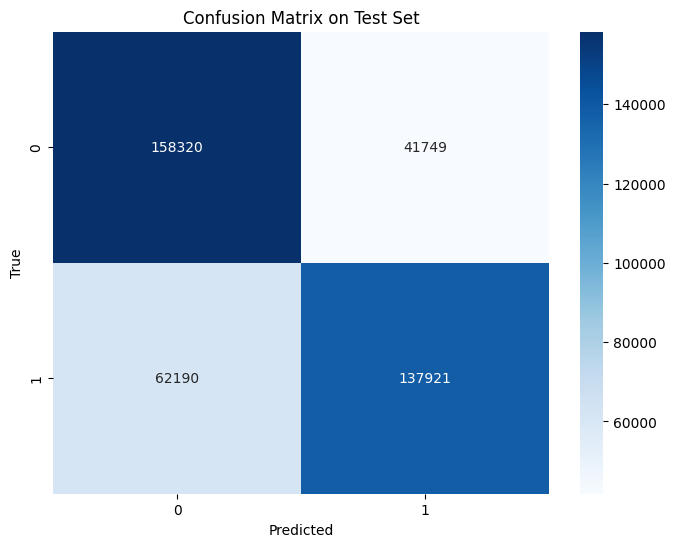

In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_fold_performance(estimator, X, y, fold_idx, fold):

    train_idx, val_idx = fold
    X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
    y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

    if isinstance(estimator, MultinomialNB):
        scaler = MinMaxScaler()
        X_fold_train = scaler.fit_transform(X_fold_train)
        X_fold_val = scaler.transform(X_fold_val)

    estimator.fit(X_fold_train, y_fold_train)
    y_pred = estimator.predict(X_fold_val)
    y_pred_proba = estimator.predict_proba(X_fold_val)[:, 1]

    metrics = {
        'fold': fold_idx + 1,
        'accuracy': accuracy_score(y_fold_val, y_pred),
        'precision': precision_score(y_fold_val, y_pred),
        'recall': recall_score(y_fold_val, y_pred),
        'f1': f1_score(y_fold_val, y_pred),
        'auc_roc': roc_auc_score(y_fold_val, y_pred_proba)
    }

    cm = confusion_matrix(y_fold_val, y_pred)
    metrics['tn'], metrics['fp'], metrics['fn'], metrics['tp'] = cm.ravel()

    return metrics, y_pred_proba, y_fold_val

def optimize_naive_bayes_detailed(X, y, cv=5):

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    nb_classifiers = {
        'gaussian': (GaussianNB(), {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}),
        'multinomial': (MultinomialNB(), {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0], 'fit_prior': [True, False]}),
        'bernoulli': (BernoulliNB(), {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0], 'fit_prior': [True, False]})
    }

    best_results = {}
    all_metrics = []

    for nb_type, (classifier, param_grid) in nb_classifiers.items():
        print(f"\n{'-'*50}")
        print(f"Evaluating {nb_type} Naive Bayes...")

        grid_search = GridSearchCV(
            estimator=classifier,
            param_grid=param_grid,
            cv=skf,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )

        if nb_type == 'multinomial':
            scaler = MinMaxScaler()
            X_scaled = scaler.fit_transform(X)
            X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        else:
            X_scaled = X

        grid_search.fit(X_scaled, y)

        print(f"\nBest Parameters for {nb_type}:", grid_search.best_params_)
        print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

        best_model = grid_search.best_estimator_
        fold_metrics = []
        fold_predictions = []
        fold_true_values = []

        for fold_idx, fold in enumerate(skf.split(X_scaled, y)):
            metrics, y_pred_proba, y_true = evaluate_fold_performance(
                best_model, X_scaled, y, fold_idx, fold
            )
            metrics['model_type'] = nb_type
            fold_metrics.append(metrics)
            fold_predictions.append(y_pred_proba)
            fold_true_values.append(y_true)

            print(f"\nFold {fold_idx + 1} Metrics:")
            print(f"Accuracy: {metrics['accuracy']:.4f}")
            print(f"Precision: {metrics['precision']:.4f}")
            print(f"Recall: {metrics['recall']:.4f}")
            print(f"F1-Score: {metrics['f1']:.4f}")
            print(f"AUC-ROC: {metrics['auc_roc']:.4f}")
            print("\nConfusion Matrix:")
            print(f"TN: {metrics['tn']}, FP: {metrics['fp']}")
            print(f"FN: {metrics['fn']}, TP: {metrics['tp']}")

        all_metrics.extend(fold_metrics)

        plt.figure(figsize=(8, 6))
        for fold_idx in range(cv):
            fpr, tpr, _ = roc_curve(
                fold_true_values[fold_idx],
                fold_predictions[fold_idx]
            )
            plt.plot(
                fpr, tpr,
                label=f'Fold {fold_idx + 1} (AUC = {fold_metrics[fold_idx]["auc_roc"]:.4f})'
            )

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves for {nb_type} Naive Bayes (All Folds)')
        plt.legend()
        plt.show()

        best_results[nb_type] = {
            'model': best_model,
            'params': grid_search.best_params_,
            'score': grid_search.best_score_
        }

    metrics_df = pd.DataFrame(all_metrics)

    print("\nAverage Metrics by Model Type:")
    avg_metrics = metrics_df.groupby('model_type').agg({
        'accuracy': ['mean', 'std'],
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'auc_roc': ['mean', 'std']
    })
    print(avg_metrics)

    best_model_type = max(best_results.items(), key=lambda x: x[1]['score'])[0]
    best_model = best_results[best_model_type]['model']

    return best_model, best_results, metrics_df

best_model, best_results, metrics_df = optimize_naive_bayes_detailed(X_train, y_train)

y_pred = best_model.predict(X_test)
print("\nFinal Test Set Performance:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

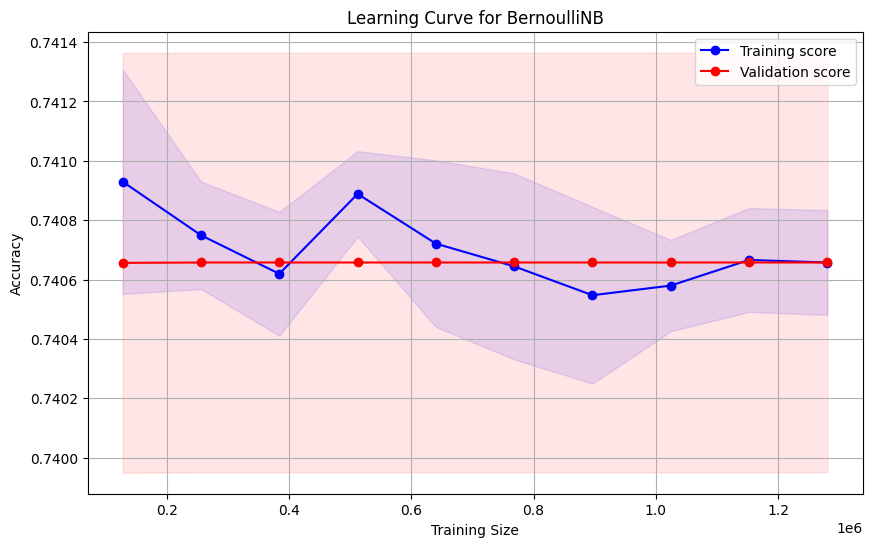

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)):

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        train_sizes=train_sizes,
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation score')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='red', alpha=0.1)

    plt.xlabel('Training Size')
    plt.ylabel(scoring.capitalize())
    plt.title(f'Learning Curve for {estimator.__class__.__name__}')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

plot_learning_curve(best_model, X_train, y_train, cv=5, scoring='accuracy')


In [ ]:
import numpy as np

indices = np.random.choice(len(X_test), size=10, replace=False)
sample_inputs = X_test.iloc[indices]
true_labels = y_test.iloc[indices]

predictions = best_model.predict(sample_inputs)
predicted_labels = predictions

for i in range(len(indices)):
    print(f"Sample Index: {indices[i]}")
    print(f"True Label: {true_labels.iloc[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")
    print("-" * 30)
